In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import wave
import IPython.display as ipd # load a local WAV file and PLAY!!!
import librosa
import librosa.display
import os
import glob

In [2]:
set_a = pd.read_csv('inputsound/set_a.csv')
set_b = pd.read_csv('inputsound/set_b.csv')
set_a_timing = pd.read_csv('inputsound/set_a_timing.csv')
print(f"Shape a = {set_a.shape}")
print(f"Shape b = {set_b.shape}")
print(f"Shape a_timing = {set_a_timing.shape}")

Shape a = (176, 4)
Shape b = (656, 4)
Shape a_timing = (390, 4)


### Concat set_a and set-b

In [3]:
train_ab = pd.concat([set_a, set_b])

In [4]:
train_ab.isnull().sum()

dataset       0
fname         0
label       247
sublabel    683
dtype: int64

## Labels

In [5]:
train_ab.groupby(['label','dataset']).count()

fname  sublabel
label      dataset                 
artifact   a           40         0
extrahls   a           19         0
extrastole b           46         0
murmur     a           34         0
           b           95        29
normal     a           31         0
           b          320       120

In [51]:
train_ab

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


 # Moving to frequency domain

In [62]:
normal_file = 'inputsound/set_a/normal__201105021654.wav'
signal, sr = librosa.load(normal_file, sr = 22050)
ipd.Audio(normal_file)

In [68]:
from scipy.signal import butter , filtfilt
fc = 400

w = fc/(sr/2)
b,a = butter(3,w , btype = "lowpass") #lpf
x = filtfilt(b,a, signal)
x = x/x.max()
ipd.Audio(x, rate = sr)

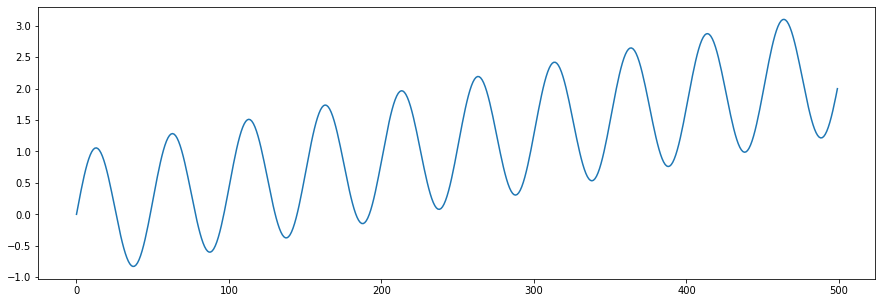

In [64]:
#SENOIDAL
f = 440
t = np.linspace(0,2,2*sr)
a = 100*t
x = np.sin(2*np.pi*f*t) + a
plt.figure(figsize=(15,5))
plt.plot(x[:sr//f*10])
ipd.Audio(x, rate = sr)


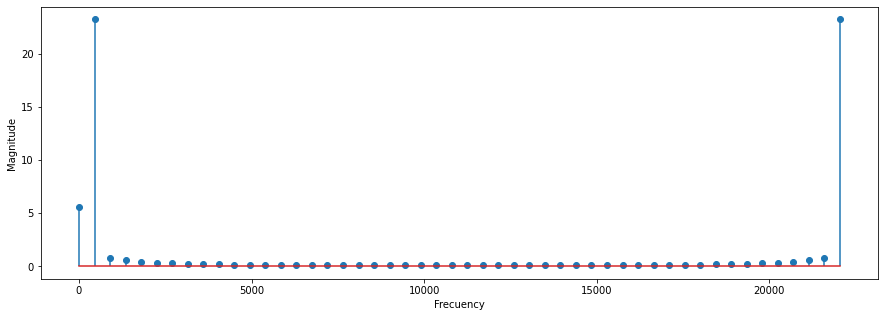

In [65]:
fft = np.fft.fft(x, n = 50)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr , len(magnitude)) #linspace gives us a number of evenly spaced numbers in an interval

#Power spectrum
plt.figure(figsize=(15, 5))
plt.stem(frequency, magnitude)
plt.xlabel("Frecuency")
plt.ylabel("Magnitude")
plt.show()

## FFT --> Spectrum

This fft returns a 1D array with as many values as the total number of samples in the waveform. 

At each value we have a complex value. We want the magnitude od the complex value(absolute value). These magnitudes indicate the contribution of each frequency to the total wave.

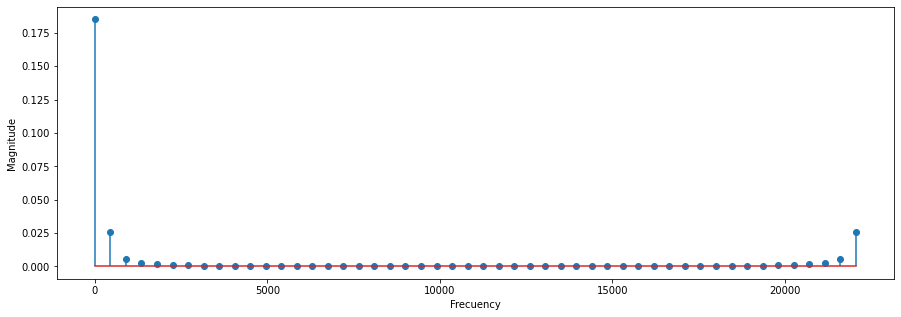

In [26]:
fft = np.fft.fft(x, n = 50)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr , len(magnitude)) #linspace gives us a number of evenly spaced numbers in an interval

#Power spectrum
plt.figure(figsize=(15, 5))
plt.stem(frequency, magnitude)
plt.xlabel("Frecuency")
plt.ylabel("Magnitude")
plt.show()

The plot is simetrical, which is a propiety of the fft. The only part of the plot with information is very little compare to the rest.

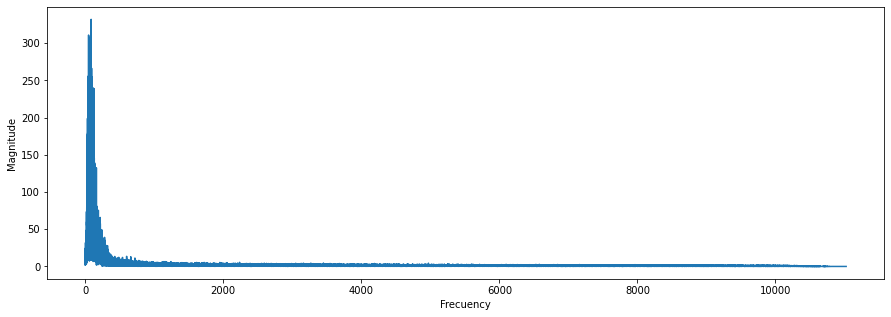

In [8]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]
#Power spectrum
plt.figure(figsize=(15, 5))
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frecuency")
plt.ylabel("Magnitude")
plt.show()

## stft

What we want to do is understanding how these frequencies contribute to the overal sound. IN order to do that we need a short time fourier transform, a stft or spectogram.

In the spectrogram the amplitude itselft is represented by a color.

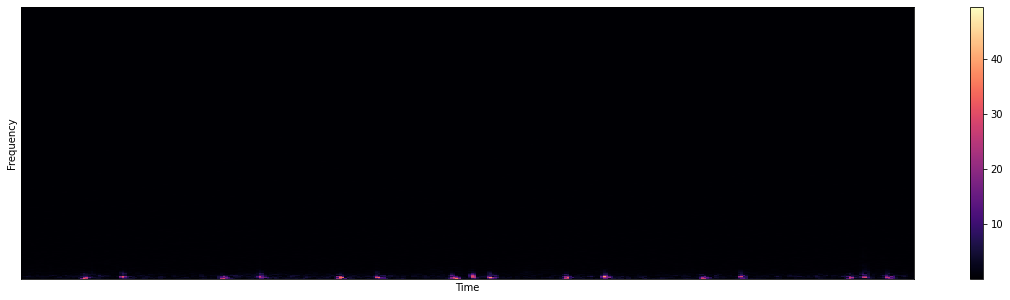

In [9]:
# number of samples per fft
n_fft = 2048 
# Sliding to the right
hop_length = 512
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft) # magnitude of complex numbers

#spechow to visualize spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(spectrogram, sr=sr,hop_length =hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

This does not look like a song where there are more frequencies in ligther colors. Here we can see pretty clearly the frequencies contribution.

The scale is bad, let's try a logarithmic one...*suprise, it's decibels!*

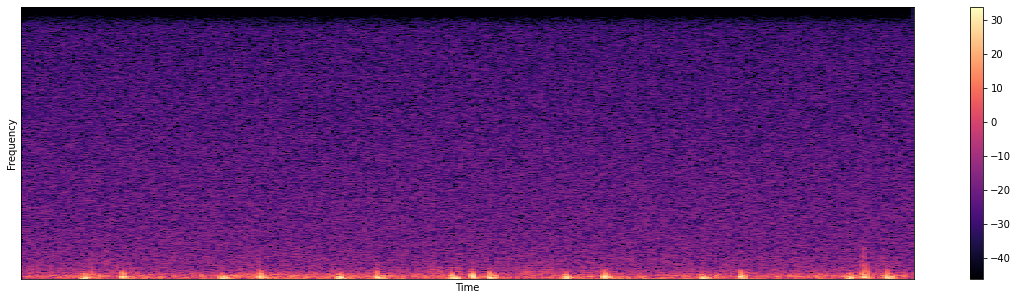

In [10]:
plt.figure(figsize=(20, 5))
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr,hop_length =hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

## MFCC, la pera limonera

n_mfcc = number of coefficients that we want to extract. A standard value for music is 13, let's start using that.

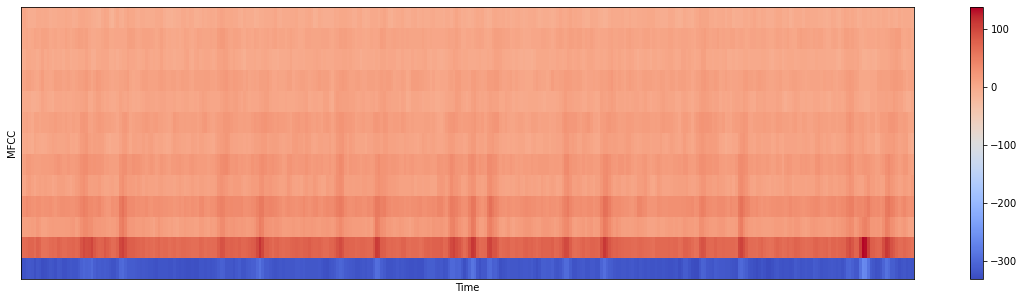

In [11]:
MFCCs = librosa.feature.mfcc(signal, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

plt.figure(figsize=(20, 5))
librosa.display.specshow(MFCCs, sr=sr,hop_length =hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

We need to segment the data in order to have more data.

In [71]:
fc = 400

w = fc/(sr/2)
b,a = butter(3,w , btype = "lowpass") #lpf
x = filtfilt(b,a, signal)
x = x/x.max()
ipd.Audio(x, rate = sr)

In [69]:
def get_data(path):
    X,y = [],[]
    for file in glob.glob(path+"/*"):
        signal, sr = librosa.load(file, sr = 22050,res_type='kaiser_fast')
        X.append(signal)
        y.append(file.split("\\")[-1].split("_")[0])
        
    X = np.concatenate(X)
    y = np.array(y).reshape(-1,1)
    
    return X,y

X,y = get_data("inputsound/set_a")

In [ ]:
DATA_PATH = 'inputsound/set_a'
STORE_PATH = 'data.json'
SAMPLE_RATE =22050
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(data_path, store_path, n_mfcc=13 , n_fft=2048 , hop_length=512, num_segments=5):
    #Dictionary to store data
    data = {
        "mapping" = [], # normal, murmur...
        "mfcc" = [], #training
        "labels" = [] # targets [0,0,1,0,1,1,1]
    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
    
    # loop throght the sounds
    for i, (dirpath, dirnames,filenames) in enumerate(os.walk(data_path)): #label as keys for the sound files
        # ensure that we are not in the root level
        if dirpath is no data_path:
            # We want to save the class in mapping
            dirpath_components = dirpath.split("/") #categories 
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            
            # process files for a specific category
            for f i filenames:
                # load audio files
                file_path = os.path.join(dirpath, f) 
                sinal, sr = librosa.load(file_path , sr = SAMPLE_RATE)
                
                #process egments extracting mfcc and storing data
                for s in range (num_segments):
                    start_sample = num_samples_per_segment * s # 
                    finish_sample = start_sample + num_samples_per_segment
                    
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                                sr = sr, 
                                                n_fft = n_fft,
                                                n_mfcc = n_mfcc,
                                                hop_length = hop_length
                                                )
                    